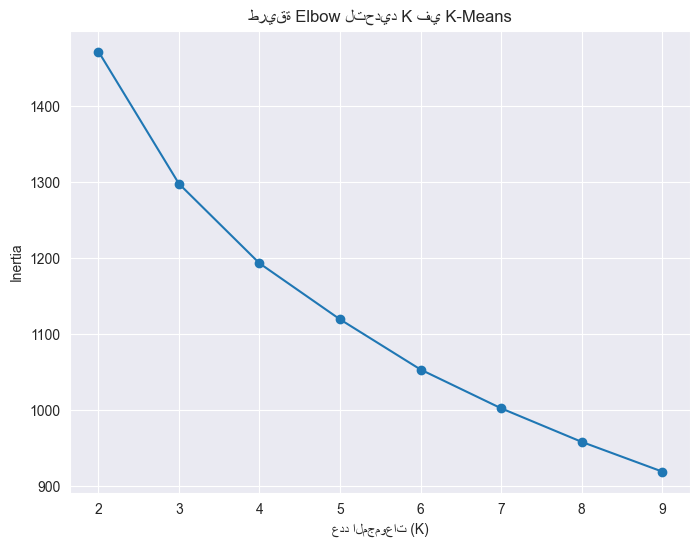

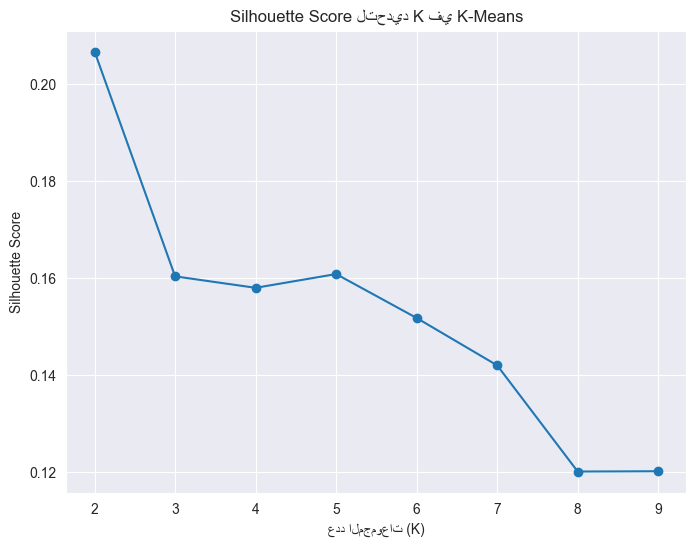

عدد المجموعات الأمثل (K): 2
Adjusted Rand Index لـ K-Means: 0.2139


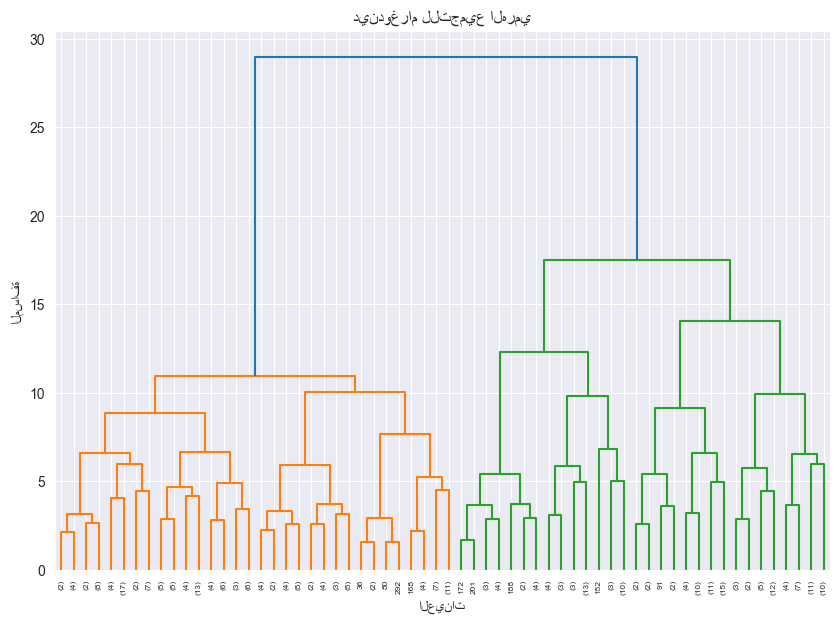

Adjusted Rand Index للتجميع الهرمي: 0.1675
         Method  Silhouette Score  Adjusted Rand Index
0       K-Means          0.252577             0.213933
1  Hierarchical          0.227792             0.167451


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np
import os

# التأكد من وجود المجلدات
os.makedirs('../results/evaluation', exist_ok=True)
os.makedirs('../data', exist_ok=True)

# تحميل البيانات
data = pd.read_csv('../data/selected_features.csv')  # تصحيح اسم الملف
X = data

# تحميل عمود target من البيانات الأصلية للمقارنة
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data_original = pd.read_csv(url, names=columns)
data_original = data_original.replace('?', np.nan)
data_original['ca'] = data_original['ca'].astype(float)
data_original['thal'] = data_original['thal'].astype(float)
data_original = data_original.fillna(data_original.mean())
y_true = (data_original['target'] > 0).astype(int)  # تحويل إلى تصنيف ثنائي

# 1. K-Means Clustering
inertia = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# رسم طريقة Elbow
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, marker='o')
plt.xlabel('عدد المجموعات (K)')
plt.ylabel('Inertia')
plt.title('طريقة Elbow لتحديد K في K-Means')
plt.savefig('../results/evaluation/kmeans_elbow.png')
plt.show()

# رسم Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('عدد المجموعات (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score لتحديد K في K-Means')
plt.savefig('../results/evaluation/kmeans_silhouette.png')
plt.show()

# اختيار K الأمثل بناءً على Silhouette Score أو Elbow
optimal_k = K[np.argmax(silhouette_scores)]  # اختيار K بناءً على أعلى Silhouette Score
print(f'عدد المجموعات الأمثل (K): {optimal_k}')
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X)

# حساب Adjusted Rand Index لـ K-Means
kmeans_ari = adjusted_rand_score(y_true, data['KMeans_Cluster'])
print(f'Adjusted Rand Index لـ K-Means: {kmeans_ari:.4f}')

# 2. Hierarchical Clustering
linked = linkage(X, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('ديندوغرام للتجميع الهرمي')
plt.xlabel('العينات')
plt.ylabel('المسافة')
plt.savefig('../results/evaluation/hierarchical_dendrogram.png')
plt.show()

# تحديد المجموعات من التجميع الهرمي
hierarchical_clusters = fcluster(linked, t=optimal_k, criterion='maxclust')
data['Hierarchical_Cluster'] = hierarchical_clusters

# حساب Adjusted Rand Index للتجميع الهرمي
hierarchical_ari = adjusted_rand_score(y_true, data['Hierarchical_Cluster'])
print(f'Adjusted Rand Index للتجميع الهرمي: {hierarchical_ari:.4f}')

# حفظ البيانات مع تسميات التجميع
data.to_csv('../data/clustered_heart_disease.csv', index=False)

# حفظ مقاييس التقييم
clustering_metrics = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical'],
    'Silhouette Score': [silhouette_score(X, data['KMeans_Cluster']), silhouette_score(X, data['Hierarchical_Cluster'])],
    'Adjusted Rand Index': [kmeans_ari, hierarchical_ari]
})
clustering_metrics.to_csv('../results/evaluation/clustering_metrics.csv', index=False)
print(clustering_metrics)